## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.callbacks import ModelCheckpoint, EarlyStopping

# *****************************************************
## Import And Preprocess Data Set

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Co2/FinalCo2.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert Effective date type to datetime
df["Date"] = pd.to_datetime(df["Date"])
# Remove timezone from effective date column
# df['DATE'] = pd.to_datetime(df['DATE']).dt.tz_localize(None)
df.head(2)

,Date,Value
0,2000-01-01,369.45
1,2000-02-01,369.71


In [ ]:
df.tail()

,Date,Value
287,2023-12-01,421.86
288,2024-01-01,422.80
289,2024-02-01,424.62
290,2024-03-01,425.38
291,2024-04-01,426.57


In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df['DATE'], df['DCOILWTICO'],  linestyle='-',color='green')
plt.xlabel('Effective Date')
plt.ylabel('Total Total_ASSET')
plt.title('Total_ASSET over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

KeyError: 'DATE'

<Figure size 1500x600 with 0 Axes>

In [ ]:
DF_Test=df.tail(7)

df=df.loc[df['DATE']<='2024-05-21']

In [ ]:
df.set_index('Date', inplace=True)

df.head()

,Value
Date,
2000-01-01,369.45
2000-02-01,369.71
2000-03-01,370.75
2000-04-01,371.98
2000-05-01,371.74


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1254 entries, 2019-05-30 to 2024-05-30
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DCOILWTICO          1254 non-null   float64
 1   YEAR                1254 non-null   int64  
 2   MONTH               1254 non-null   int64  
 3   DAY                 1254 non-null   int64  
 4   WEEK_OF_MONTH       1254 non-null   int64  
 5   DAY_OF_WEEK         1254 non-null   int64  
 6   DAY_NAME            1254 non-null   object 
 7   DCOILWTICO_lag_1    1253 non-null   float64
 8   DCOILWTICO_lag_2    1252 non-null   float64
 9   DCOILWTICO_lag_3    1251 non-null   float64
 10  DCOILWTICO_lag_4    1250 non-null   float64
 11  DCOILWTICO_lag_5    1249 non-null   float64
 12  DCOILWTICO_lag_6    1248 non-null   float64
 13  DCOILWTICO_lag_7    1247 non-null   float64
 14  DCOILWTICO_mean_5   1250 non-null   float64
 15  DCOILWTICO_mean_10  1245 non-null   f

In [ ]:
train = df[:190]
valid = df[190:250]
test = df[250:]

scaler = MinMaxScaler()

# Fit scaler on training data and transform all subsets
train_data = scaler.fit_transform(train[['Value']])
validate_data = scaler.transform(valid[['Value']])
test_data = scaler.transform(test[['Value']])

print("Train data size:", len(train_data))
print("Validation data size:", len(validate_data))
print("Test data size:", len(test_data))


Train data size: 190
Validation data size: 60
Test data size: 42


In [ ]:
from keras.layers import Bidirectional
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10 # Number of time steps to look back
X_train, y_train = create_sequences(train_data, seq_length)
X_val,y_val=create_sequences(validate_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()
# # Early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)

# # Fit the model
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 64)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 50)                3

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_val)

2/2 [==============================] - 0s 6ms/step


In [ ]:
# Inverse transform the predictions and actual values
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_val = scaler.inverse_transform(y_val.reshape(-1, 1))


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

train_mse = mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_val, test_predict)

# Calculate RMSE for training and test sets
train_rmse = sqrt(train_mse)
test_rmse = sqrt(test_mse)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Train MSE: 0.25978819419725946
Test MSE: 1.2308957631362636
Train RMSE: 0.5096942163663027
Test RMSE: 1.1094574183519905


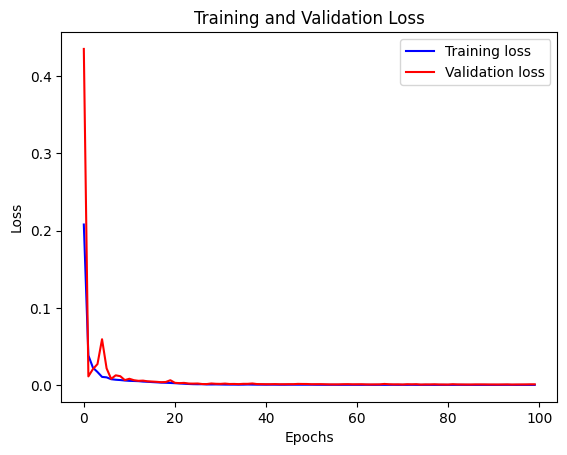

In [ ]:
import matplotlib.pyplot as plt

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]  # Retrieve validation loss
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")  # Plot validation loss with red color

    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")



2/2 [==============================] - 0s 6ms/step


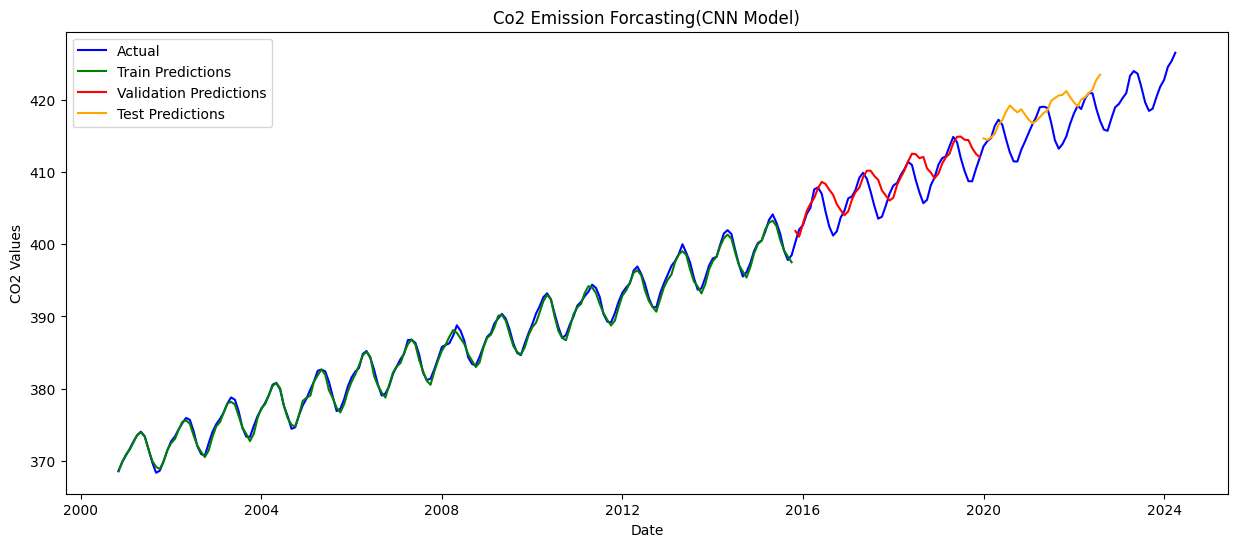

In [ ]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
val_predictions = model.predict(X_val)

train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
val_predictions = scaler.inverse_transform(val_predictions)


plt.figure(figsize=(15, 6))

plt.plot(df.index[seq_length:], df['Value'][seq_length:], label='Actual', color='blue')

plt.plot(df.index[seq_length:seq_length+len(train_predictions)], train_predictions, label='Train Predictions',color='green')


val_pred_index = range(seq_length+len(train_predictions), seq_length+len(train_predictions)+len(val_predictions))
plt.plot(df.index[val_pred_index], val_predictions, label='Validation Predictions', color='red')

test_pred_index = range(seq_length+len(train_predictions)+len(val_predictions), seq_length+len(train_predictions)+len(val_predictions)+len(test_predictions))
plt.plot(df.index[test_pred_index], test_predictions, label='Test Predictions', color='orange')

plt.title('Co2 Emission Forcasting(CNN Model)')
plt.xlabel('Date')
plt.ylabel('CO2 Values')
plt.legend(loc='upper left')
plt.show()